### Dimensionality Reduction

#### Importing Libs

In [102]:
from sklearn.datasets import fetch_lfw_pairs
from sklearn.datasets import fetch_covtype
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter
import seaborn as sns

#### Importing Data

In [ ]:
lfw_pairs = fetch_lfw_pairs()
covtype = fetch_covtype()

In [10]:
lfw_pairs.data.shape, Counter(lfw_pairs.target)

((2200, 5828), Counter({1: 1100, 0: 1100}))

In [12]:
covtype.data.shape, Counter(covtype.target)

((581012, 54),
 Counter({5: 9493,
          2: 283301,
          1: 211840,
          7: 20510,
          3: 35754,
          6: 17367,
          4: 2747}))

### LFW Pairs

#### Splitting Data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(lfw_pairs.data, lfw_pairs.target, test_size=0.4, random_state=42)

#### PCA + Logistic Regression + Score Calibration

In [27]:
feature_selector = FeatureUnion([
     ("original", make_pipeline('passthrough')),
     ("pca", PCA())
])
pipeline = Pipeline([
    ('feature_selector', feature_selector),
    ('lr', LogisticRegression(max_iter=10000))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_selector',
                 FeatureUnion(transformer_list=[('original',
                                                 Pipeline(steps=[('passthrough',
                                                                  'passthrough')])),
                                                ('pca', PCA())])),
                ('lr', LogisticRegression(max_iter=10000))])

In [45]:
y_test_hat = pipeline.predict_proba(X_test)
print(f'ROC AUC: {roc_auc_score(y_test, y_test_hat[:,1])}')

ROC AUC: 0.5688971089665434


<Axes: ylabel='Count'>

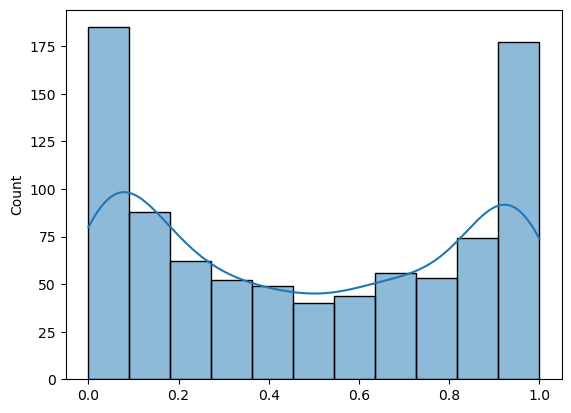

In [37]:
sns.histplot(y_test_hat[:,1], kde=True)

In [46]:
calibrated_clf = CalibratedClassifierCV(pipeline, cv='prefit', method='isotonic')
calibrated_clf.fit(X_train, y_train)
calibrated_probabilities = calibrated_clf.predict_proba(X_test)
print(f'ROC AUC: {roc_auc_score(y_test, calibrated_probabilities[:,1])}')

ROC AUC: 0.5618425946973611


<Axes: ylabel='Count'>

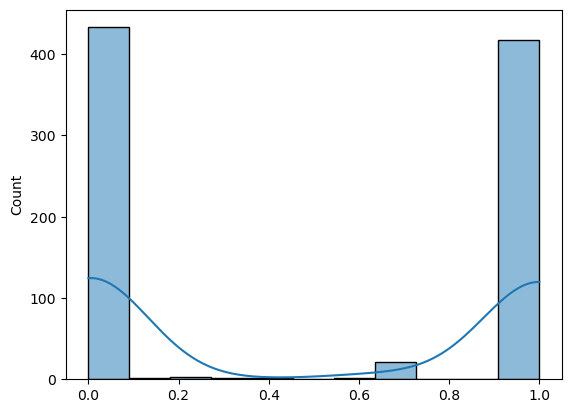

In [47]:
sns.histplot(calibrated_probabilities[:,1], kde=True)

### Cov Type

#### Splitting Data

In [51]:
X_train, X_test, y_train, y_test = train_test_split(covtype.data, covtype.target, test_size=0.4, random_state=42)

#### RFE + Decition Tree + Random Forest

In [63]:
rfe = RFE(DecisionTreeClassifier(max_depth=3), step=1)
rfe.fit(X_train, y_train)

RFE(estimator=DecisionTreeClassifier(max_depth=3))

In [82]:
[*map(lambda x: x[0], filter(lambda x: x[1], zip(covtype.feature_names, rfe.support_)))]

['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'Wilderness_Area_0',
 'Wilderness_Area_1',
 'Wilderness_Area_2',
 'Soil_Type_3',
 'Soil_Type_22',
 'Soil_Type_23',
 'Soil_Type_24',
 'Soil_Type_25',
 'Soil_Type_26',
 'Soil_Type_27',
 'Soil_Type_28',
 'Soil_Type_29',
 'Soil_Type_30',
 'Soil_Type_31',
 'Soil_Type_32',
 'Soil_Type_33',
 'Soil_Type_34']

In [83]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

#### Bagging Classifier

In [99]:
clf = BaggingClassifier()
clf.fit(X_train_rfe, y_train)
y_test_hat = clf.predict(X_test_rfe)
print(f'Accuracy: {accuracy_score(y_test, y_test_hat)}')

Accuracy: 0.9520965555818507


#### AdaBoost Classifier

In [101]:
clf = AdaBoostClassifier()
clf.fit(X_train_rfe, y_train)
y_test_hat = clf.predict(X_test_rfe)
print(f'ROC AUC: {accuracy_score(y_test, y_test_hat)}')

ROC AUC: 0.6132699382543405
